In [31]:
import numpy as np
import matplotlib.pyplot as plt
import openjij as oj
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

In [32]:
class DecisionStump:
    """
    决策桩：基于单一特征的阈值判断
    属性：
      - feature_index: 特征索引
      - threshold: 阈值
      - polarity: 极性（1 表示特征值 < 阈值时输出 -1，否则 +1；-1 则相反）
    """
    def __init__(self, feature_index: int, threshold: float, polarity: int = 1):
        self.feature_index = feature_index
        self.threshold = threshold
        self.polarity = polarity

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        对输入数据 X（形状 [n_samples, n_features]）进行预测，返回 -1 或 +1
        """
        feature_values = X[:, self.feature_index]
        preds = np.ones(len(feature_values), dtype=int)
        if self.polarity == 1:
            preds[feature_values < self.threshold] = -1
        else:
            preds[feature_values > self.threshold] = -1
        return preds

In [33]:
def load_data(classes=(0, 1), test_size: float = 0.2, random_state: int = 42):
    """
    加载 sklearn 的 digits 数据集，筛选标签为 classes 中的两类样本，
    将第一个类映射为 -1，第二个类映射为 +1，
    并切分为训练集和测试集。

    参数:
      - classes: 二分类类别的元组，例如 (3, 8)
      - test_size: 测试集比例
      - random_state: 随机种子

    返回:
      X_train, X_test, y_train, y_test
    """
    digits = load_digits()
    X = digits.data
    y = digits.target
    class_a, class_b = classes
    mask = (y == class_a) | (y == class_b)
    X = X[mask]
    y = y[mask]
    # 标签映射：class_a -> -1, class_b -> +1
    y = np.where(y == class_a, -1, 1)
    return train_test_split(X, y, test_size=test_size, random_state=random_state)


def generate_weak_classifiers(X: np.ndarray, num_thresholds: int = 10):
    """
    根据训练数据 X，针对每个特征按 num_thresholds 个等距阈值生成一系列决策桩。

    参数:
      - X: 训练特征数组，形状 [n_samples, n_features]
      - num_thresholds: 每个特征上生成的阈值数目

    返回:
      弱分类器列表，每个元素都是 DecisionStump 实例
    """
    stumps = []
    n_features = X.shape[1]
    for feature_idx in range(n_features):
        values = X[:, feature_idx]
        min_v, max_v = values.min(), values.max()
        thresholds = np.linspace(min_v, max_v, num_thresholds)
        for thresh in thresholds:
            stumps.append(DecisionStump(feature_idx, thresh, polarity=1))
            stumps.append(DecisionStump(feature_idx, thresh, polarity=-1))
    return stumps

In [34]:
def build_qubo_matrix(stumps, X, y, lambda_reg=0.01):
    """
    构建 QBoost 的 QUBO 矩阵，将弱分类器的组合问题映射为二次无约束二元优化问题。

    Q[j,j] = C * G[j,j] - alpha * c[j] + lambda_reg
    Q[j,k] = C * G[j,k]  (j<k)

    其中:
      - G[j,k] = sum_i h_j(x_i) h_k(x_i)
      - c[j]   = sum_i y_i h_j(x_i)
      - C = 1 / N^2, alpha = 2 / N
    """
    N = len(y)
    M = len(stumps)
    # H[i,j] = h_j(x_i)
    H = np.vstack([clf.predict(X) for clf in stumps]).T  # shape (N, M)
    G = H.T.dot(H)                                      # shape (M, M)
    c = (H * y[:, None]).sum(axis=0)                    # shape (M,)

    Q = {}
    C = 1.0 / (N**2)
    alpha = 2.0 / N
    for j in range(M):
        # 对角项
        Q[(j, j)] = C * G[j, j] - alpha * c[j] + lambda_reg
        # 非对角项
        for k in range(j+1, M):
            qjk = C * G[j, k]
            if qjk != 0.0:
                Q[(j, k)] = qjk
    return Q


def qboost_train(stumps, X_train, y_train, lambda_reg=0.01, num_reads=100):
    Q = build_qubo_matrix(stumps, X_train, y_train, lambda_reg)
    sampler = oj.SQASampler()

    # 修正后的 schedule：每行 [s, beta, sweeps]
    schedule = [
        [0.0, 0.1, 500],  # s=0 时 β=0.1，做 500 步
        [1.0, 5.0, 500]   # s=1 时 β=5.0，做 500 步
    ]

    # 同时指定 trotter 切片数（可选，默认为 1）
    response = sampler.sample_qubo(
        Q,
        num_reads=num_reads,
        trotter=8,
        schedule=schedule
    )

    best = response.first.sample
    sel_idx = [j for j, bit in best.items() if bit == 1]
    return [stumps[j] for j in sel_idx]


def predict_strong(stumps, X):
    """
    对测试数据 X 应用强分类器，返回 +1/-1 预测。
    """
    # 所有弱分类器预测值累加，取符号
    agg = sum(clf.predict(X) for clf in stumps)
    return np.sign(agg)

使用 50 个弱分类器进行 QBoost
选中了 24 个弱分类器构建强分类器
Stump 0: feature=36, thr=1.778, pol=-1
Stump 1: feature=36, thr=1.778, pol=1
Stump 2: feature=28, thr=1.778, pol=-1
Stump 3: feature=28, thr=5.333, pol=-1
Stump 4: feature=36, thr=7.111, pol=-1
Stump 5: feature=36, thr=5.333, pol=1
Stump 6: feature=36, thr=7.111, pol=1
Stump 7: feature=28, thr=0.000, pol=-1
Stump 8: feature=28, thr=7.111, pol=-1
Stump 9: feature=30, thr=2.667, pol=1
Stump 10: feature=28, thr=8.889, pol=-1
Stump 11: feature=28, thr=8.889, pol=1
Stump 12: feature=36, thr=8.889, pol=-1
Stump 13: feature=30, thr=1.333, pol=1
Stump 14: feature=38, thr=2.889, pol=1
Stump 15: feature=38, thr=2.889, pol=-1
Stump 16: feature=44, thr=5.333, pol=-1
Stump 17: feature=27, thr=8.889, pol=-1
Stump 18: feature=20, thr=8.889, pol=-1
Stump 19: feature=20, thr=10.667, pol=1
Stump 20: feature=27, thr=7.111, pol=-1
Stump 21: feature=20, thr=7.111, pol=-1
Stump 22: feature=44, thr=7.111, pol=-1
Stump 23: feature=20, thr=12.444, pol=-1
测试集准确率: 97.22%


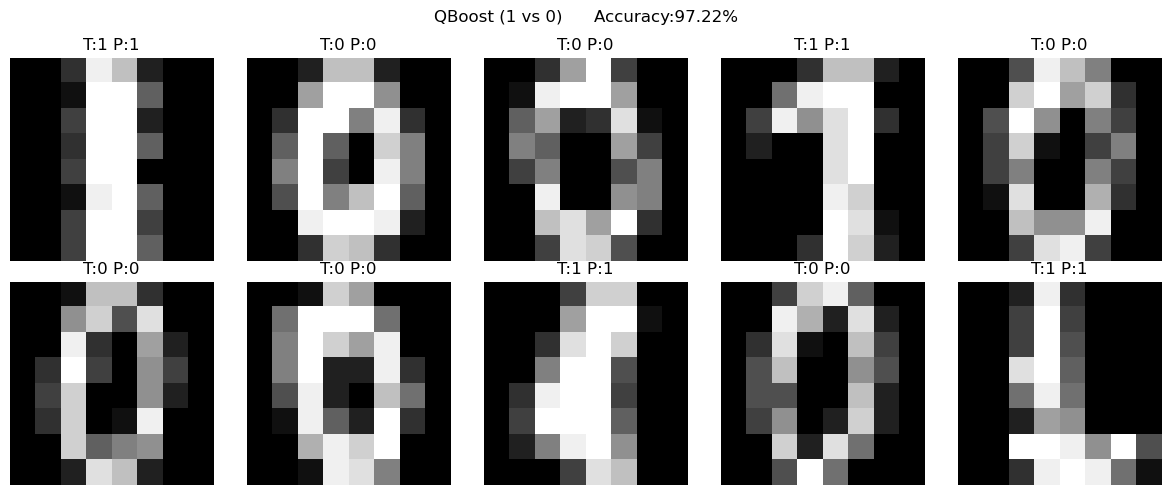

In [35]:
# 1. 加载数据（可自定义分类对）
classes = (1, 0)  # 二分类数字，例如 (1, 0)
X_train, X_test, y_train, y_test = load_data(classes=classes, test_size=0.2)

# 2. 生成弱分类器并筛选前 M 个
all_stumps = generate_weak_classifiers(X_train, num_thresholds=10)
# 按与标签相关性排序
scores = np.abs([(clf.predict(X_train) * y_train).sum() for clf in all_stumps])
M = 50
top_idx = np.argsort(-np.array(scores))[:M]
stumps = [all_stumps[i] for i in top_idx]
print(f"使用 {len(stumps)} 个弱分类器进行 QBoost")

# 3. 训练 QBoost，选出强分类器中的弱分类器子集
selected = qboost_train(stumps, X_train, y_train, lambda_reg=0.01, num_reads=50)
print(f"选中了 {len(selected)} 个弱分类器构建强分类器")
for i, stump in enumerate(selected):
    print(f"Stump {i}: feature={stump.feature_index}, thr={stump.threshold:.3f}, pol={stump.polarity}")

# 4. 在测试集上进行预测
preds = predict_strong(selected, X_test)
acc = (preds == y_test).mean()
print(f"测试集准确率: {acc * 100:.2f}%")

# 5. 可视化：展示前 10 个测试样本的图像与分类结果
num_show = 10
fig, axes = plt.subplots(2, num_show//2, figsize=(12, 5))
axes = axes.flatten()
for idx, ax in enumerate(axes):
    img = X_test[idx].reshape(8, 8)
    true_label = y_test[idx]
    pred_label = preds[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(f"T:{classes[int((true_label+1)/2)]} P:{classes[int((pred_label+1)/2)]}")
    ax.axis('off')
fig.suptitle(f"QBoost ({classes[0]} vs {classes[1]})      Accuracy:{acc*100:.2f}%")
plt.tight_layout()
plt.show()